<a href="https://colab.research.google.com/github/NongNNew/Project_499/blob/main/Project_499_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CNN**

## Setup

In [1]:
!pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=8a7f7ade11ab2f8cdd94f0c15b16db7bdc94d29ed87043a9b3527f816c5e54a0
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python-speech-features


In [2]:
import librosa
import numpy as np
import pandas as pd
from time import time
from glob import glob
import tensorflow as tf
from tensorflow import keras 
import python_speech_features
import matplotlib.pyplot as plt
from scipy.signal.windows import hamming
from sklearn.metrics import classification_report,  plot_confusion_matrix

In [3]:
np.random.seed(1)
tf.random.set_seed(1)

In [4]:
# Upload audio files from github
!git clone https://github.com/NongNNew/Project_499.git

Cloning into 'Project_499'...
remote: Enumerating objects: 1565, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 1565 (delta 51), reused 96 (delta 39), pack-reused 1444
Receiving objects: 100% (1565/1565), 237.73 MiB | 28.38 MiB/s, done.
Resolving deltas: 100% (199/199), done.
Checking out files: 100% (1145/1145), done.


## Prepare dataset

In [5]:
# Name of vegetables and fruits 52 types of 56 classes
fruit_veget = ['กระชาย','กระท้อน','กระเทียม1','กระเทียม2','กระเพรา','กล้วยน้ำว้า','กล้วยหอม',
               'ข้าวโพด','ไข่น้ำ',
               'ตะขบไทย','ตะไคร้',
               'ถั่วฝักยาว','ถั่วลันเตา','ถั่วลิสง',
               'ทับทิม',
               'น้อยหน่า','น้ำเต้า',
               'ผักกระเฉด','ผักกุยช่าย','ผักขึ้นช่าย','ผักชะอม','ผักชี','ผักชีฝรั่ง','ผักตำลึง',
               'มะปราง','มะพลับ','มะละกอ','มะกรูด','มะเขือพวง','มะเขือเทศ','มะระ','มะรุม','มะตูม','มันแกว1','มันแกว2','มันเทศ','มันฝรั่ง','มันสำปะหลัง',
               'บวบ','ใบชะพลู1','ใบชะพลู2','ใบบัวบก','ใบแมงลัก','ใบยอ',
               'พริกขี้หนู','พริกสด','พุทรา','เพกา',
               'ฝรั่ง',
               'ฟัก','ฟักทอง',
               'สับปะรด','สะเดา','สะระแหน่',
               'หัวหอม1','หัวหอม2']

# Audio data source
source = {'audio_time':[],
          'sampling_rate':[],
          'feature_extraction':[],
          'label':[],
          'description':[]}

In [6]:
def feature_mfcc(y,sr):
    return (python_speech_features.mfcc(signal=y, 
                                    samplerate=sr, 
                                    winlen= 512/sr, 
                                    winstep= 160/sr,
                                    numcep= 13,
                                    nfilt= 40, 
                                    nfft= 512,
                                    lowfreq= 0,
                                    highfreq= None,
                                    preemph= 0.97, 
                                    ceplifter= 0,
                                    winfunc= hamming))

In [7]:
for types in fruit_veget:
    audio_files = glob('/content/Project_499/Record_audio/' + str(types) + '/*.wav')

    for audio in audio_files:
        y,sr = librosa.load(audio,duration=5,offset=0)
        source['description'].append(str(types))
        source['audio_time'].append(y)
        source['sampling_rate'].append(sr)
        source['feature_extraction'].append(feature_mfcc(y,sr))
        source['label'].append(fruit_veget.index(types))

In [8]:
# tranform dictionary to dataframe 
df = pd.DataFrame.from_dict(source)
df

,audio_time,sampling_rate,feature_extraction,label,description
0,"[-0.004928589, -0.0049591064, -0.0048980713, -...",22050,"[[-12.959169471954294, -4.281586674957866, 6.4...",0,กระชาย
1,"[-7.6293945e-05, -0.00015258789, -0.0001068115...",22050,"[[-13.963624272836848, -10.834306371234895, 4....",0,กระชาย
2,"[0.0004119873, 0.00061035156, 0.0005340576, 0....",22050,"[[-14.031458292064183, -9.71991818216831, 3.08...",0,กระชาย
3,"[-0.0009765625, -0.001449585, -0.001373291, -0...",22050,"[[-13.841251857084886, -10.542052145166839, 1....",0,กระชาย
4,"[1.5258789e-05, -3.0517578e-05, 4.5776367e-05,...",22050,"[[-13.895163210723114, -10.534242113550562, 0....",0,กระชาย
...,...,...,...,...,...
1115,"[-0.0001373291, -9.1552734e-05, -7.6293945e-05...",22050,"[[-14.082713493333289, -12.10106746611324, -0....",55,หัวหอม2
1116,"[-0.0001373291, -0.0001373291, -9.1552734e-05,...",22050,"[[-13.96050509926212, -9.312697095263102, 1.11...",55,หัวหอม2
1117,"[3.0517578e-05, -6.1035156e-05, 6.1035156e-05,...",22050,"[[-14.050800633014068, -10.083539910076112, 2....",55,หัวหอม2
1118,"[0.0, -1.5258789e-05, 3.0517578e-05, -3.051757...",22050,"[[-14.18512183869517, -10.797166196952473, 3.3...",55,หัวหอม2


In [9]:
Test = pd.DataFrame(columns=source.keys())

# Create test data

for description in np.unique(df['description']):
    imp_test = df[df['description']==description].sample(5,random_state=1)
    Test = pd.concat([Test,imp_test], axis=0)
Train = df.drop(Test.index)

X_train = np.array(Train['feature_extraction'].to_list())
X_test = np.array(Test['feature_extraction'].to_list())
y_train = np.array(Train['label'].to_list())
y_test = np.array(Test['label'].to_list())

In [10]:
# Proportion of data
y_train.shape, y_test.shape

((840,), (280,))

## Build cnn model

In [11]:
def create_cnn_model():
    np.random.seed(1)
    tf.random.set_seed(1)
    model = None
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(128, 5, input_shape=(X_train.shape[1], X_train.shape[2], 1), activation='relu'))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.MaxPool2D())
    model.add(keras.layers.Conv2D(64, 5, activation='relu',padding='same'))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.MaxPool2D())
    model.add(keras.layers.Conv2D(64, 5, activation='relu',padding='same'))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.MaxPool2D())
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Dense(len(np.unique(df['label'])), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    model.summary()

    return model

## Find best parameter

### find dropout and batch_size

In [18]:
# Use scikit-learn to grid search the batch size and epochs
import numpy
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# create model
model = KerasClassifier(build_fn=create_cnn_model)

# define the grid search parameters
batch_size = np.arange(10,210,10)
epochs = np.arange(10,310,10)
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5).fit(X_train[:,:,:,None],y_train)

Streaming output truncated to the last 5000 lines.
68/68 [==============================] - 1s 9ms/step - loss: 0.1530 - accuracy: 0.9673
Epoch 83/300
68/68 [==============================] - 1s 9ms/step - loss: 0.1278 - accuracy: 0.9732
Epoch 84/300
68/68 [==============================] - 1s 9ms/step - loss: 0.1888 - accuracy: 0.9539
Epoch 85/300
68/68 [==============================] - 1s 9ms/step - loss: 0.2724 - accuracy: 0.9539
Epoch 86/300
68/68 [==============================] - 1s 9ms/step - loss: 0.1522 - accuracy: 0.9643
Epoch 87/300
68/68 [==============================] - 1s 9ms/step - loss: 0.0922 - accuracy: 0.9717
Epoch 88/300
68/68 [==============================] - 1s 9ms/step - loss: 0.0788 - accuracy: 0.9807
Epoch 89/300
68/68 [==============================] - 1s 9ms/step - loss: 0.1650 - accuracy: 0.9628
Epoch 90/300
68/68 [==============================] - 1s 10ms/step - loss: 0.1163 - accuracy: 0.9717
Epoch 91/300
68/68 [==============================] - 1s 9ms/

KeyboardInterrupt: ignored

In [19]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

NameError: ignored

In [ ]:
# Use scikit-learn to grid search the batch size and epochs
import numpy
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# create model
model = KerasClassifier(build_fn=create_cnn_model)

# define the grid search parameters
batch_size = np.arange(10,310,10)
epochs = np.arange(10,210,10)
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5).fit(X_train[:,:,:,None],y_train)

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

## Train model

In [12]:
# Train model
start = time()

model_cnn = create_cnn_model(X_train)
history = model_cnn.fit(X_train[:,:,:,None], y_train, epochs=100, validation_data=(X_test[:,:,:,None],y_test),batch_size=80,verbose=0)

end = time()
print(f'time: {end-start} sec')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 683, 9, 128)       3328      
_________________________________________________________________
dropout (Dropout)            (None, 683, 9, 128)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 341, 4, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 341, 4, 64)        204864    
_________________________________________________________________
dropout_1 (Dropout)          (None, 341, 4, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 170, 2, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 170, 2, 64)        1

## Evaluate and predict test set

In [13]:
# Evaluate model
print(f'Test Accuracy: {model_cnn.evaluate(X_test[:,:,:,None],y_test,verbose=0)[1]}')

Test Accuracy: 0.9642857313156128


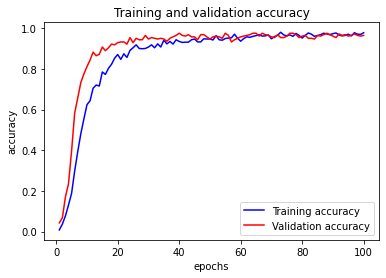

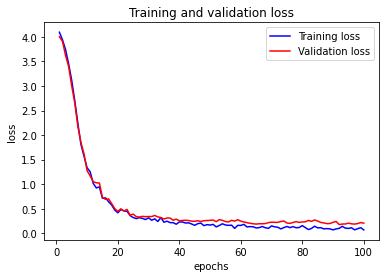

In [14]:
# Learning curve
# plot the accuracy and loss plots between training and validation data
# verify overfitting or underfit 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
x = range(1,len(acc)+1)

plt.plot(x,acc,'b',label='Training accuracy')
plt.plot(x,val_acc,'r',label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.figure()

plt.plot(x,loss,'b',label='Training loss')
plt.plot(x,val_loss,'r',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [15]:
# classification report
predicted_classes = np.argmax(np.round(model_cnn.predict(X_test[:,:,:,None])),axis=1)
correct = np.where(predicted_classes==y_test)[0]
target_names = [f"Class {label}" for label in range(len(np.unique(df['label'])))]

print(f"From {len(y_test)} labels're founding {len(correct)} correct labels.")
print(f'Accuracy: {len(correct)/len(y_test)}')
print('')
print(classification_report(y_test, predicted_classes, target_names=target_names))

From 280 labels're founding 266 correct labels.
Accuracy: 0.95

              precision    recall  f1-score   support

     Class 0       0.38      1.00      0.56         5
     Class 1       1.00      1.00      1.00         5
     Class 2       1.00      1.00      1.00         5
     Class 3       1.00      0.40      0.57         5
     Class 4       1.00      1.00      1.00         5
     Class 5       1.00      1.00      1.00         5
     Class 6       1.00      1.00      1.00         5
     Class 7       0.71      1.00      0.83         5
     Class 8       1.00      1.00      1.00         5
     Class 9       1.00      1.00      1.00         5
    Class 10       1.00      1.00      1.00         5
    Class 11       1.00      1.00      1.00         5
    Class 12       1.00      1.00      1.00         5
    Class 13       1.00      1.00      1.00         5
    Class 14       1.00      1.00      1.00         5
    Class 15       1.00      1.00      1.00         5
    Class 16     

## Other people 
men and woman each 10 audio file.

In [ ]:
import numpy as np
np.random.seed(77)

random_fruit_veget = np.random.choice(np.unique(df['description']),10,replace=False).tolist()
print(random_fruit_veget)

['ผักกุยช่าย', 'ทับทิม', 'ใบชะพลู1', 'พริกขี้หนู', 'มันสำปะหลัง', 'ฟักทอง', 'มะพลับ', 'หัวหอม2', 'ใบชะพลู2', 'บวบ']


In [ ]:
import pandas as pd

# Audio data source
other_source = {'audio_time':[],
                'sampling_rate':[],
                'feature_extraction':[],
                'label':[],
                'description':[]}

for types in random_fruit_veget:
    audio_files = glob('/content/Project_499/Record_other_audio/' + str(types) + '/*.wav')

    for audio in audio_files:
        y,sr = librosa.load(audio,duration=5,offset=0)
        other_source['description'].append(str(types))
        other_source['audio_time'].append(y)
        other_source['sampling_rate'].append(sr)
        other_source['feature_extraction'].append(feature_mfcc(y,sr))

other_source['label'] = [18,18,14,14,39,39,44,44,37,37,50,50,25,25,55,55,40,40,38,38]
other_df = pd.DataFrame.from_dict(other_source)

In [ ]:
other_X_test = np.array(other_df['feature_extraction'].to_list())
other_y_test = np.array(other_df['label'].to_list())

In [ ]:
# classification report
predicted_classes = np.argmax(np.round(model_cnn.predict(other_X_test[:,:,:,None])),axis=1)
correct = np.where(predicted_classes==other_y_test)[0]
target_names = [f"Class {label}" for label in np.unique(other_source['label'])]

print(f"From {len(other_y_test)} labels're founding {len(correct)} correct labels.")
print(f'Accuracy: {len(correct)/len(other_y_test)}')

From 20 labels're founding 6 correct labels.
Accuracy: 0.3
